Document classification is a fundamental machine learning task. It is used for all kinds of applications, like filtering spam, routing support request to the right support rep, <br> language detection, genre classification, sentiment analysis, <br> and many more.

In [63]:
import pandas as pd
import numpy as np

import texthero as hero
from texthero import preprocessing as ppe

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string

In [64]:
df = pd.read_csv('data/tickets.csv', header=0)
df.head()

,Title,Resolution,class
0,Need Ethernet access,Please connect the LAN cable to the red port o...,41
1,Create new account and share the username and ...,"Go to URL : accountsetup.com, Enter personal d...",35
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36
3,Login credetials are not working.,"Go to URL : password.reset.com, Enter you logi...",36
4,New Account is needed for a new joinee.,"Go to URL : accountsetup.com, Enter personal d...",35


In [65]:
custom_pipeline = [ ppe.fillna, ppe.lowercase, ppe.remove_punctuation, ppe.remove_stopwords, ppe.remove_whitespace, ppe.remove_digits]

df['title_resolution'] = df['Title'] + df['Resolution']

df['clean_resolution'] = hero.clean(df['title_resolution'], custom_pipeline)


c:\users\ajitrajput\appdata\local\programs\python\python37\lib\site-packages\texthero\preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
c:\users\ajitrajput\appdata\local\programs\python\python37\lib\site-packages\texthero\preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)


In [66]:
df.count(axis=0)

Title               236
Resolution          236
class               236
title_resolution    236
clean_resolution    236
dtype: int64

In [67]:
df.isnull().any()

Title               False
Resolution          False
class               False
title_resolution    False
clean_resolution    False
dtype: bool

In [68]:
lem = WordNetLemmatizer()

def word_lem(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

In [69]:
df['clean_resolution']  = df['clean_resolution'].apply(word_lem)
df.sample(5)

,Title,Resolution,class,title_resolution,clean_resolution
178,Are spaces allowed in e-mail addresses?,Just like an Internet URL no spaces are allow...,12,Are spaces allowed in e-mail addresses? Just l...,space allowed e mail address like internet url...
228,"There are black borders on my screen, what am ...",If the resolution was recently changed it is ...,8,"There are black borders on my screen, what am ...",black border screen resolution recently change...
189,How do I delete internet cookies?,Microsoft Internet Explorer users can go to '...,15,How do I delete internet cookies? Microsoft In...,delete internet cooky microsoft internet explo...
203,Is Windows equipped with an anti-virus program?,All versions of Microsoft Windows do not come...,1,Is Windows equipped with an anti-virus program...,window equipped anti virus program version mic...
147,Login credentials do not work.,"Go to URL : password.reset.com, Enter you logi...",36,Login credentials do not work.Go to URL : pass...,login credential work go url password reset co...


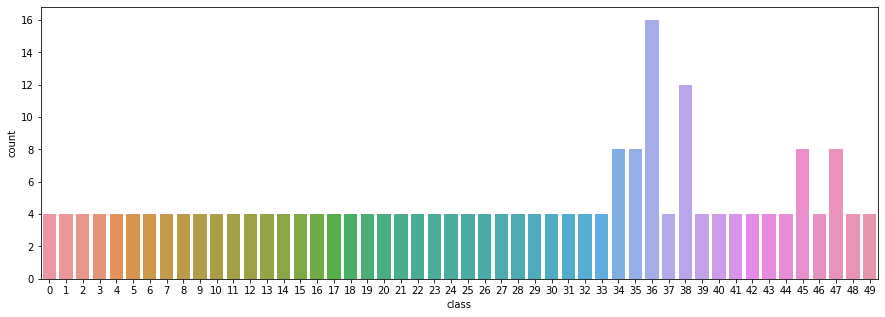

In [70]:
plt.figure(figsize=(15, 5))
sns.countplot(x='class', data=df)

plt.show()

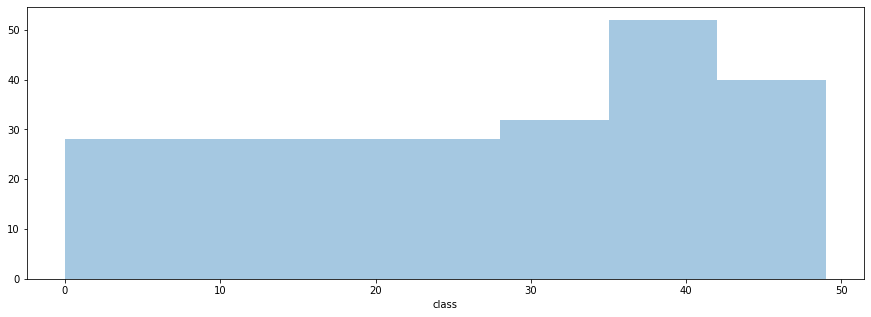

In [71]:
plt.figure(figsize=(15, 5))
sns.distplot(df["class"], kde=False)
plt.show()

In [72]:
trainDF = pd.DataFrame()
trainDF['text'] = df['clean_resolution']
trainDF['label'] = df['class']

In [73]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

In [74]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [75]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

c:\users\ajitrajput\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [76]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature here .

In [77]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.9491525423728814
NB, WordLevel TF-IDF:  0.4576271186440678
NB, N-Gram Vectors:  0.559322033898305
NB, CharLevel Vectors:  0.3898305084745763


Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by <br> estimating probabilities using a logistic/sigmoid function. <br>
One can read more about logistic regression here

In [78]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

LR, Count Vectors:  1.0
LR, WordLevel TF-IDF:  0.6949152542372882
LR, N-Gram Vectors:  0.6949152542372882
LR, CharLevel Vectors:  0.6949152542372882


Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. <br>The model extracts a best possible hyper-plane / line that segregates the two classes. <br> One can read more about it here

In [79]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.9322033898305084


Random Forest (Bagging) models are a type of ensemble models, particularly bagging models. <br> They are part of the tree based model family. One can read more about Bagging and random forests here

In [80]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  1.0
RF, WordLevel TF-IDF:  1.0


Boosting models are another type of ensemble models part of tree based models. <br>Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a <br> family of machine learning algorithms that convert weak learners to strong ones. <br>A weak learner is defined to be a classifier that is only slightly <br> correlated with the true classification <br> (it can label examples better than random guessing). <br> <br> Read more about these models here

In [81]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(eval_metric='mlogloss'), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(eval_metric='mlogloss'), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(eval_metric='mlogloss'), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

c:\users\ajitrajput\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Xgb, Count Vectors:  0.9491525423728814
Xgb, WordLevel TF-IDF:  1.0
Xgb, CharLevel Vectors:  1.0
